# Logistic Regression

This is an implementation of logistic regression in Python, following from Andrew Ng's ML course. Although the course does not make use of the gradient descent approach, I chose to implement it for my own learning. After this, I do it using scipy's optimization library.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op

### Main Functions

In [2]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def compute_gradient(theta, X, y):
    m, n = X.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(X @ theta)
    gradient = X.T @ ((h - y) / m)
    
    return gradient.flatten()

def compute_cost(theta,x,y):
    m, n = x.shape
    theta = theta.reshape((n, 1))
    y = y.reshape((m, 1))
    h = sigmoid(x @ theta)

    J = -(np.sum(y * np.log(h) + (1 - y) * np.log(1-h)))/m
    return J

def gradient_descent(X, y, iters, a):
    m, n = X.shape
    theta = np.zeros((n, 1))
    
    costs = []
    for i in range(iters):
        z = X @ theta
        h = sigmoid(z)
        gradient = compute_gradient(theta, X, y).reshape(-1,1)#(X.T @ (h - y)) / y.size
        theta -= a * gradient
        cost = compute_cost(theta, X, y)
        costs.append(cost)
    return theta, costs

def compute_boundary(X, theta):
    dbx = np.array([min(X[:,1])-2,  max(X[:,1])+2])
    dby = (-1/theta[2]) * (theta[1] * dbx + theta[0])
    return dbx, dby

def plot_data(X, y, decisionboundary=None):
    fig, ax = plt.subplots()
    posclass = X[np.where(y == 1)[0]]
    negclass = X[np.where(y == 0)[0]]
    ax.scatter(posclass[:, 0], posclass[:, 1], label='pos')
    ax.scatter(negclass[:, 0], negclass[:, 1], edgecolor='C0', c='none', label='neg')
    
    if decisionboundary is not None:
        ax.plot(decisionboundary[0], decisionboundary[1], c='red')
        
    ax.legend()
    plt.show()
    return

In [3]:
# READ IN THE DATA
path = r'C:\Users\L\Documents\Machine Learning with Andrew Ng\02_logistic_regression'
data = np.loadtxt(fname=f'{path}//ex2data1.txt', delimiter=',')
X = data[:, :-1] # case, age, weight, sex, VO2_max, heart_disease
y = data[:, -1].reshape(-1, 1)

# Add an intercept column
X = np.c_[(np.ones(len(X)), X)]

### Using Gradient Descent

In [4]:
thetas_gd, costs = gradient_descent(X, y, 5000000, 0.001)

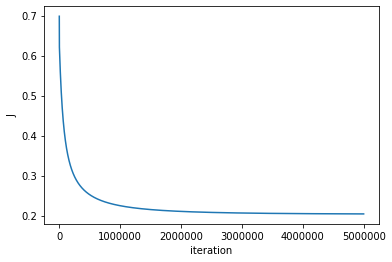

Cost of theta found by gradient descent: 0.20416128092026029.
Expected (approx): 0.203

Thetas found:
[[-23.12353639]
 [  0.18993761]
 [  0.18497899]]

Expected thetas:
[[-25.161
 0.206
 0.201]]


In [5]:
fig, ax = plt.subplots()
ax.plot(costs)
ax.set_xlabel('iteration')
ax.set_ylabel('J')
plt.show()
print(f"Cost of theta found by gradient descent: {costs[-1]}.")
print(f"Expected (approx): 0.203\n")
print(f"Thetas found:\n{thetas_gd}\n")
print(f"Expected thetas:\n[[-25.161\n 0.206\n 0.201]]")

It is also interesting to see what happens when we use gradient descent with a larger learning rate $\alpha$:

In [6]:
thetas_gd_slow, costs_slow = gradient_descent(X, y, 500000, 0.005)
print(thetas_gd_slow)

[[-29.99604184]
 [  0.23675871]
 [  0.23161717]]


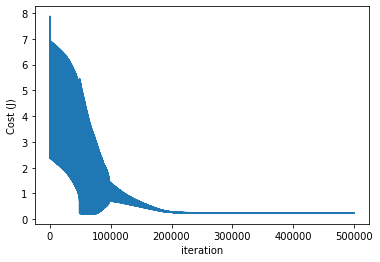

Final cost (J): 0.23735857050014988


In [7]:
fig, ax = plt.subplots()
ax.plot(costs_slow)
ax.set_xlabel('iteration')
ax.set_ylabel('Cost (J)')
plt.show()
print(f"Final cost (J): {costs_slow[-1]}")

The cost function seems to oscillate back and forth while gradually reducing, as was mentioned on the course. It is interesting to visualise what this looks like - in this case, it seems that rather than being stuck, a minimum may be possible, but it can clearly be made more efficiently by reducing $\alpha$.

### Using Scipy's Optimization

Scipy's optimization package computes optimal theta values much faster, which is probably why Andrew Ng makes use of it in the course rather than gradient descent.

In [8]:
def opti(X, y):
    m, n = X.shape
    initial_theta = np.zeros(n)
    result = op.minimize(fun = compute_cost, 
                     x0 = initial_theta, 
                     args = (X, y),
                     method = 'TNC',
                     jac = compute_gradient)
    return result


result = opti(X, y)
print(result)
thetas_opt = result.x
cost_opt = result.fun # compute_cost(thetas_opt, X, y)

     fun: 0.2034977015894744
     jac: array([9.09336555e-09, 9.26443416e-08, 4.83973251e-07])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 36
     nit: 17
  status: 0
 success: True
       x: array([-25.16131865,   0.20623159,   0.20147149])


In [9]:
print(f"Cost of theta found by gradient descent: {cost_opt}.")
print(f"Expected (approx): 0.203\n")
print(f"Thetas found:\n{thetas_opt}\n")
print(f"Expected thetas:\n[[-25.161\n 0.206\n 0.201]]")

Cost of theta found by gradient descent: 0.2034977015894744.
Expected (approx): 0.203

Thetas found:
[-25.16131865   0.20623159   0.20147149]

Expected thetas:
[[-25.161
 0.206
 0.201]]


We can see that the thetas obtained from Scipy's optimization package are similar to those from gradient descent, only it took much less time to compute.

### Plotting Results

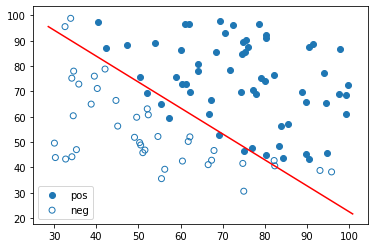

In [10]:
# Compute the decision boundary
db_opt = compute_boundary(X[:, 1:], thetas_opt)
# Plot it
plot_data(X[:, 1:], y, (db_opt))

### Testing the Accuracy of the Model

In [11]:
# Create a prediction array for GD & opt approaches
threshold = 0.5
ypred_gd = (X@thetas_gd>=threshold)*1
ypred_opt = (X@thetas_opt>=threshold)*1

In [12]:
# Compute accuracy for both approaches
opt_acc = (y[np.where(ypred_opt == y.flatten())].size / y.size) * 100
gd_acc = (y[np.where(ypred_gd == y)].size / y.size) * 100
# Print acc
print(f"Accuracy for optimisation: {opt_acc}%")
print(f"Accuracy for gradient descent: {gd_acc}%")

Accuracy for optimisation: 89.0%
Accuracy for gradient descent: 88.0%


### Predicting New Values

In [13]:
adm_pr = sigmoid(np.array([1, 45, 85]) @ thetas_opt)
print(f"For a student with scores 45 and 85, we predict an admission probability of: {adm_pr*100}%")

For a student with scores 45 and 85, we predict an admission probability of: 77.62906242781953%
